In [4]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, BatchNormalization, LeakyReLU, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Activation, Concatenate
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tqdm.notebook import tqdm
# Бібліотека для роботи з GIF
import imageio
from IPython.display import Image
#
import matplotlib.pyplot as plt
import os
import ipywidgets

In [5]:
DEPTH = 10
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = train_images / 255 # нормалізуємо в [0, 1]
train_labels = np.array(to_categorical(train_labels, DEPTH))

11490434/11490434 [==============================] - 1s 0us/step


In [6]:
RANDOM_DIM = 100

class DataGenerator():
    def __init__(self, train_images, train_labels, batches_per_epoch, batch_size):
        self.train_images = train_images
        self.train_labels = train_labels
        self.batches_per_epoch = batches_per_epoch
        self.batch_size = batch_size

    @staticmethod
    def rand_norm(npoints=1, ndim=RANDOM_DIM):
        rand_vec = np.random.normal(0, 1, size=[npoints, ndim])
        # проекция на поверхю сфери
        # rand_vec = rand_vec / np.sqrt(np.sum(np.square(rand_vec), axis=1))[:, np.newaxis]
        return rand_vec

    def __len__(self):
        return self.batches_per_epoch

    def batch(self):
        rand_images_indexes = np.random.randint(0, train_images.shape[0], size=self.batch_size)
        image_batch = train_images[rand_images_indexes]
        labels_batch = train_labels[rand_images_indexes]
        return image_batch, labels_batch

    def __iter__(self):
        for b in tqdm(range(self.batches_per_epoch), leave=False):
            yield self.batch()

    def rand_batch(self):
        rand_vec = self.rand_norm(self.batch_size)
        rand_labels = np.random.randint(0, 10, size=[self.batch_size])
        rand_labels = np.array(to_categorical(rand_labels, DEPTH))
        return [rand_vec, rand_labels]

np.random.seed(42)
images_indexes = np.random.randint(0, len(train_images), size=16)
PICS_FROM_DATASET = [train_images[images_indexes], train_labels[images_indexes]]
FIXED_NOISE = [DataGenerator.rand_norm(16), train_labels[images_indexes]]

In [7]:
def make_generator():
    complexity = 80
    alpha = 0.2

    random_vector = Input(shape=[RANDOM_DIM])
    labels = Input(shape=[DEPTH])

    X = Concatenate()([random_vector, labels])
    # 1 шар
    X = Dense(7 * 7 * int(complexity/2),
                          input_dim=RANDOM_DIM,
                          kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02))(X)
    X = BatchNormalization()(X)
    X = LeakyReLU(alpha)(X)

    X = Reshape((7, 7, int(complexity/2)))(X)

    # 2 шар
    X = Conv2DTranspose(int(complexity),
                        kernel_size=(5, 5),
                        strides=(2, 2),
                        padding='same')(X)
    X = BatchNormalization()(X)
    X = LeakyReLU(alpha)(X)

    # 3 шар
    X = Conv2DTranspose(int(complexity),
                        kernel_size=(5, 5),
                        strides=(1, 1),
                        padding='same')(X)
    X = BatchNormalization()(X)
    X = LeakyReLU(alpha)(X)

    # 4 шар
    X = Conv2DTranspose(int(complexity),
                        kernel_size=(5, 5),
                        strides=(1, 1),
                        padding='same')(X)
    X = BatchNormalization()(X)
    X = LeakyReLU(alpha)(X)

    # 5 шар
    X = Conv2DTranspose(int(complexity),
                        kernel_size=(5, 5),
                        strides=(1, 1),
                        padding='same')(X)
    X = BatchNormalization()(X)
    X = LeakyReLU(alpha)(X)

    # 6 шар
    X = Conv2DTranspose(1,
                        kernel_size=(5, 5),
                        strides=(2, 2),
                        padding='same')(X)
    X = Activation('sigmoid')(X)

    model = Model(inputs=[random_vector, labels], outputs=X, name='generator')
    model.compile(loss='binary_crossentropy',
                  metrics=['acc'],
                  optimizer='sgd')
    model.summary()
    return model
generator = make_generator()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 110)          0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 1960)         217560      ['concatenate[0][0]']    

1/1 [==============================] - 4s 4s/step


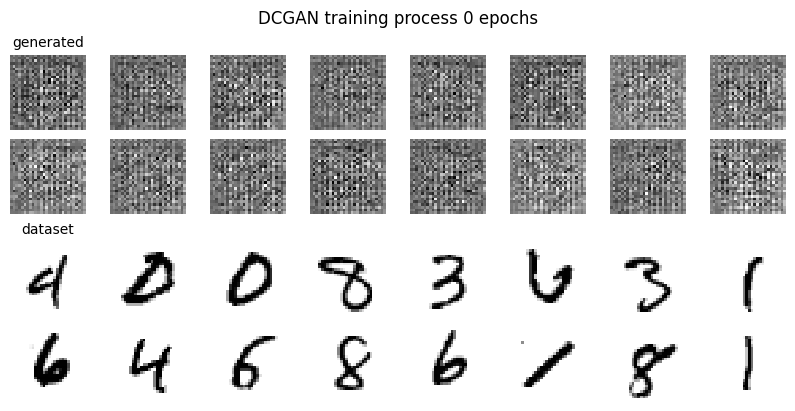

In [8]:
def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError:
        print('Folder already exists')

def plot_and_save_images(generated_images, folder_name, title, cols, rows, figsize, show=False, subtitles=False):
    fig, axs = plt.subplots(rows, cols, constrained_layout=True)
    fig.set_figheight(figsize[0])
    fig.set_figwidth(figsize[1])
    for i in range(rows):
        for j in range(cols):
            axs[i][j].imshow(generated_images[i][j], interpolation='nearest', cmap='gray_r')
            axs[i][j].axis('off')
            if not subtitles is None:
                if i == 0 and j == 0:
                    axs[i][j].set_title(subtitles[0], fontsize=10)
                if i == int(rows/2) and j == 0:
                    axs[i][j].set_title(subtitles[1], fontsize=10)

    fig.suptitle(title, fontsize=12)
    plt.savefig(os.path.join(folder_name, title + '.png'))
    if show:
        plt.show()
    plt.close()


def plot_generated_images(noise, folder_name, title, cols=8, rows=4, figsize=(4, 8), show=False, subtitles=('generated', 'dataset')):
    generated_images = generator.predict(noise)
    images = np.concatenate([generated_images, PICS_FROM_DATASET[0]])
    images = images.reshape(rows, cols, 28, 28)
    plot_and_save_images(images, folder_name, title, cols, rows, figsize, show, subtitles)


folder_name = 'GAN_pics_for_gif'
mkdir_p(os.path.join(folder_name))

title = f"DCGAN training process {0} epochs"
plot_generated_images(FIXED_NOISE, folder_name, title, show=True)

In [9]:
def optimizer():
    return tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)

In [10]:
def make_discriminator():
    complexity = 70
    drop_rate = 0.2
    alpha = 0.2

    inp = Input(shape=(28, 28, 1))
    X = inp
    # 1 шар
    X = Conv2D(int(complexity/4),
               kernel_size=(5, 5),
               strides=(2, 2),
               kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02),
               padding='same')(X)
    X = LeakyReLU(alpha)(X)
    X = Dropout(drop_rate)(X)

    # 2 шар
    X = Conv2D(int(complexity/2),
               kernel_size=(5, 5),
               strides=(2, 2),
               #kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02),
               padding='same')(X)
    X = LeakyReLU(alpha)(X)
    X = Dropout(drop_rate)(X)

    # 3 шар
    X = Conv2D(int(complexity),
               kernel_size=(5, 5),
               strides=(2, 2),
               #kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02),
               padding='same')(X)
    X = LeakyReLU(alpha)(X)
    X = Dropout(drop_rate)(X)

    # 4 шар
    X = Conv2D(int(2*complexity),
               kernel_size=(5, 5),
               strides=(1, 1),
               #kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02),
            padding='same')(X)
    X = LeakyReLU(alpha)(X)
    X = Dropout(drop_rate)(X)

    # 5 шар
    X = Conv2D(int(complexity),
               kernel_size=(5, 5),
               strides=(1, 1),
               #kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02),
               padding='same')(X)
    X = LeakyReLU(alpha)(X)
    X = Dropout(drop_rate)(X)

    # 6 шар
    X = Flatten()(X)
    X_real_fake = Dense(1, activation='sigmoid', name='real_fake')(X)
    X_labels = Dense(DEPTH, activation='softmax', name='labels')(X)

    model = Model(inputs=inp, outputs=[X_real_fake, X_labels], name='discriminator')
    model.compile(loss={'real_fake': 'binary_crossentropy',
                        'labels': 'categorical_crossentropy'},
                  loss_weights={'real_fake':1,
                                'labels': 1},
                  optimizer=optimizer(),
                  metrics={'real_fake':'acc'})

    model.summary()
    return model
discriminator = make_discriminator()

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 17)   442         ['input_3[0][0]']                
                                                                                                  
 leaky_re_lu_5 (LeakyReLU)      (None, 14, 14, 17)   0           ['conv2d[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 14, 14, 17)   0           ['leaky_re_lu_5[0][0]']          
                                                                                      

In [11]:
discriminator.predict(generator.predict(FIXED_NOISE))

1/1 [==============================] - 0s 218ms/step


[array([[0.5010665 ],
        [0.50106806],
        [0.5010633 ],
        [0.5010653 ],
        [0.5010709 ],
        [0.5010639 ],
        [0.5010653 ],
        [0.50106144],
        [0.5010664 ],
        [0.5010646 ],
        [0.50106674],
        [0.5010651 ],
        [0.5010633 ],
        [0.50106806],
        [0.5010597 ],
        [0.50106233]], dtype=float32),
 array([[0.10019781, 0.10049485, 0.09991855, 0.10023913, 0.09976427,
         0.09951238, 0.10027673, 0.09985489, 0.09928226, 0.10045913],
        [0.10019977, 0.10049348, 0.09991871, 0.10023951, 0.09976406,
         0.09951292, 0.1002749 , 0.09985626, 0.09928301, 0.10045741],
        [0.10019747, 0.10049619, 0.09991758, 0.10023899, 0.09976389,
         0.09951227, 0.10027666, 0.09985736, 0.09928333, 0.10045625],
        [0.10019835, 0.10049492, 0.09992021, 0.10023591, 0.099766  ,
         0.09951285, 0.10027497, 0.09985702, 0.09928247, 0.10045722],
        [0.10019848, 0.10049472, 0.09992038, 0.10023674, 0.09976586,
      

In [12]:
def make_gan(discriminator, generator):
    noise = generator.inputs
    image = generator(noise)
    real_vs_fake_and_label = discriminator(image)
    gan = Model(inputs=noise, outputs=real_vs_fake_and_label)
    discriminator.trainable = False
    gan.compile(loss={'discriminator':'binary_crossentropy',
                      'discriminator_1':'categorical_crossentropy'},

                optimizer=optimizer(),
                metrics={'discriminator':'acc'})
    discriminator.trainable = True
    gan.summary()
    return gan
gan = make_gan(discriminator, generator)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 generator (Functional)         (None, 28, 28, 1)    789001      ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 discriminator (Functional)     [(None, 1),          579213      ['generator[0][0]']          

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 0s 98ms/step


  0%|          | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 0s 98ms/step


  0%|          | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 0s 94ms/step


  0%|          | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 0s 80ms/step


  0%|          | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 0s 79ms/step


  0%|          | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 0s 81ms/step


  0%|          | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 0s 96ms/step


  0%|          | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 0s 117ms/step


  0%|          | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 0s 95ms/step


  0%|          | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 0s 82ms/step


  0%|          | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 0s 83ms/step


  0%|          | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 0s 96ms/step


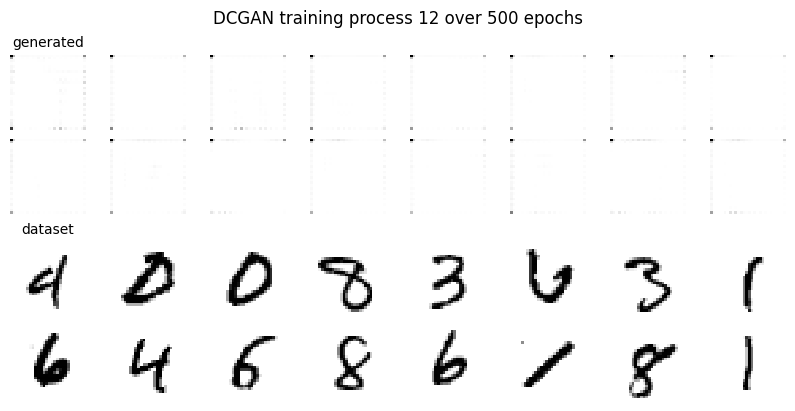

Якщо генератор і дескрімінатор сбалансовані, точність генератора прямує в 0 або 1:
0.54755859375


  0%|          | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 0s 85ms/step


  0%|          | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 0s 135ms/step


  0%|          | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 0s 100ms/step


  0%|          | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 0s 113ms/step


  0%|          | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 0s 98ms/step


  0%|          | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 0s 107ms/step


  0%|          | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 0s 99ms/step


  0%|          | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 0s 157ms/step


  0%|          | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 0s 92ms/step


  0%|          | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 0s 96ms/step


  0%|          | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 0s 101ms/step


  0%|          | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 0s 109ms/step


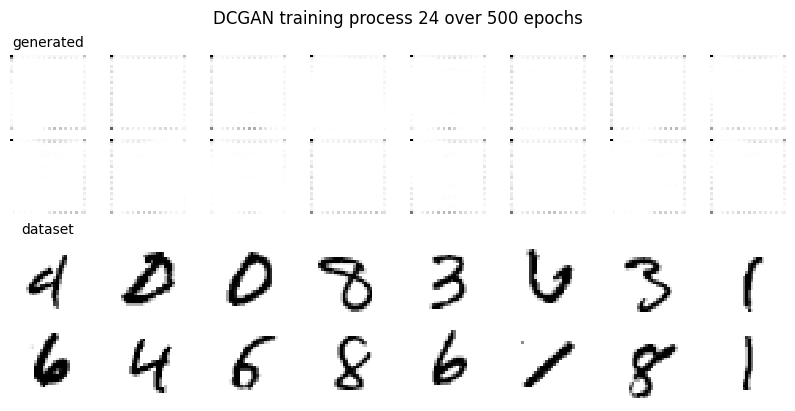

Якщо генератор і дескрімінатор сбалансовані, точність генератора прямує в 0 або 1:
0.5062825520833333


  0%|          | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 0s 85ms/step


  0%|          | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 0s 83ms/step


  0%|          | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 0s 81ms/step


  0%|          | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 0s 93ms/step


  0%|          | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 0s 82ms/step


  0%|          | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 0s 86ms/step


  0%|          | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 0s 104ms/step


  0%|          | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 0s 128ms/step


  0%|          | 0/40 [00:00<?, ?it/s]

1/4 [======>.......................] - ETA: 0s

KeyboardInterrupt: 

In [13]:
%%time
EPOCHS = 500
BATCH_SIZE = 128
data = DataGenerator(train_images, train_labels, batches_per_epoch=40, batch_size=BATCH_SIZE)
# масив для відслідковування стабільності навчання
generator_acc_follow = []
for epoch in tqdm(range(1, EPOCHS+1)):
    for images_batch, labels_batch in data:
        # Навчання дискримінатора
        noise = data.rand_batch()
        generated_images = generator.predict(noise)
        X = np.concatenate([images_batch, generated_images])
        # Згладжування цільових значень
        y_real = np.random.uniform(0.8, 1, size=[BATCH_SIZE])
        y_fake = np.random.uniform(0, 0.2, size=[BATCH_SIZE])
        y_real_fake = np.concatenate([y_real, y_fake])
        # Цільові значення міток
        y_labels = np.concatenate([labels_batch, np.zeros((BATCH_SIZE, DEPTH))])
        # навчаємо дискрімінатор
        discriminator.train_on_batch(X, [y_real_fake, y_labels])

        # Навчання генератора
        noise = data.rand_batch()
        # Вказуємо цільові значення
        y_real_fake = np.ones(BATCH_SIZE)
        # Навчаємо GAN і зберігаємо точність у масив
        generator_acc_follow.append(gan.train_on_batch(noise, [y_real_fake, noise[1]])[-1])

    # Будуємо зображення і зберігаємо його для створення .gif
    title = f"DCGAN training process {epoch} over {EPOCHS} epochs"
    if epoch%int(EPOCHS/40)==0:
        plot_generated_images(FIXED_NOISE, folder_name, title, show=True)
        print('Якщо генератор і дескрімінатор сбалансовані, точність генератора прямує в 0 або 1:')
        print(np.mean(generator_acc_follow))
        generator_acc_follow = []
    else:
        plot_generated_images(FIXED_NOISE, folder_name, title)

generator.save('generator_trained.h5')

  0%|          | 0/33 [00:00<?, ?it/s]

C:\Users\Work\AppData\Local\Temp\ipykernel_20984\110756970.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(os.path.join(folder_name, filename))


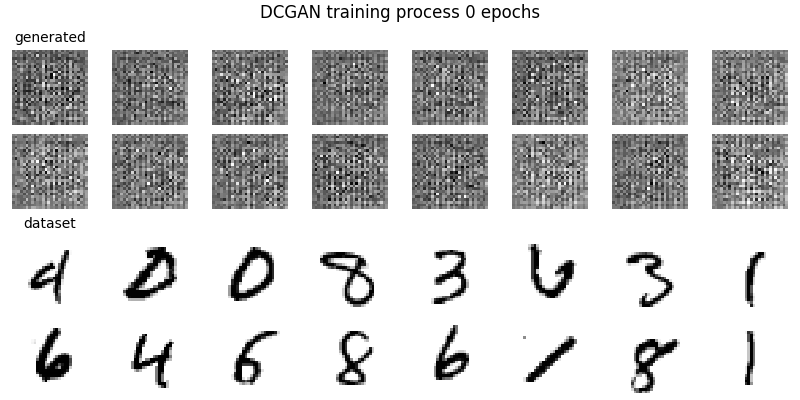

In [14]:
for folder_data in os.walk(os.path.join(folder_name)):
    all_pics_filenames = sorted(folder_data[2], key=lambda x: int(x.split()[3]))

with imageio.get_writer('DCGAN training.gif', mode='I', fps=60) as writer:
    for filename in tqdm(all_pics_filenames):
        image = imageio.imread(os.path.join(folder_name, filename))
        writer.append_data(image)

with open('DCGAN training.gif','rb') as f:
    display(Image(data=f.read(), format='png'))